In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import gc

In [2]:
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim.models.coherencemodel import CoherenceModel
import csv

In [3]:
with open('speeches-lemmatized-agg-ngrams-long.pkl', 'rb') as f:
    df = pickle.load(f)

# Exploring top topic p distributions

### Load files

145-topic LDA model

In [4]:
with open(f'topic-models/fine/doc-topics/lda_mallet_145_doc_topics.pkl', 'rb') as f:
    dt = pickle.load(f)
    
with open(f'topic-models/fine/lda_mallet_145.pkl', 'rb') as f:
    lda = pickle.load(f)

In [5]:
dt.shape

(94713, 145)

In [6]:
def review_doc(ind, n_top_p=3, n_topics=5):
    print(f'doc id: {ind}', '\n')
    
    print(f'top {n_top_p} topic ps:', np.sum(np.sort(dt[ind])[::-1][:n_top_p]), '\n')

    print('Largest doc topic probs', np.sort(dt[ind])[::-1][:12], '\n')

    for i, topic_id in enumerate(np.argsort(dt[ind])[::-1][:n_topics]):
        print(np.around( np.sort(dt[ind])[::-1][i], 3 ), topic_id)
        print(lda.print_topic(topic_id))
        print('\r')

    print(df.iloc[ind].speech)

## Plot topic p distributions

In [7]:
def get_suffix(n):
    if n==1:
        return 'st'
    elif n==2:
        return 'nd'
    elif n==3:
        return 'rd'
    else:
        return 'th'

In [8]:
# def old_topic_i_p(dt,i,j=None):
#     if j is not None:
#         return np.sum([topic_i_p(dt, n) for n in np.arange(i,j)], axis=0)
#     else:
#         return np.sort(dt, axis=1)[:, ::-1][:,i]

In [9]:
def topic_i_p(dt, n_topics, start=0):
        top_ps = np.sort(dt, axis=1)[:, ::-1][:, start : start + n_topics]
        return np.sum(top_ps, axis=1)

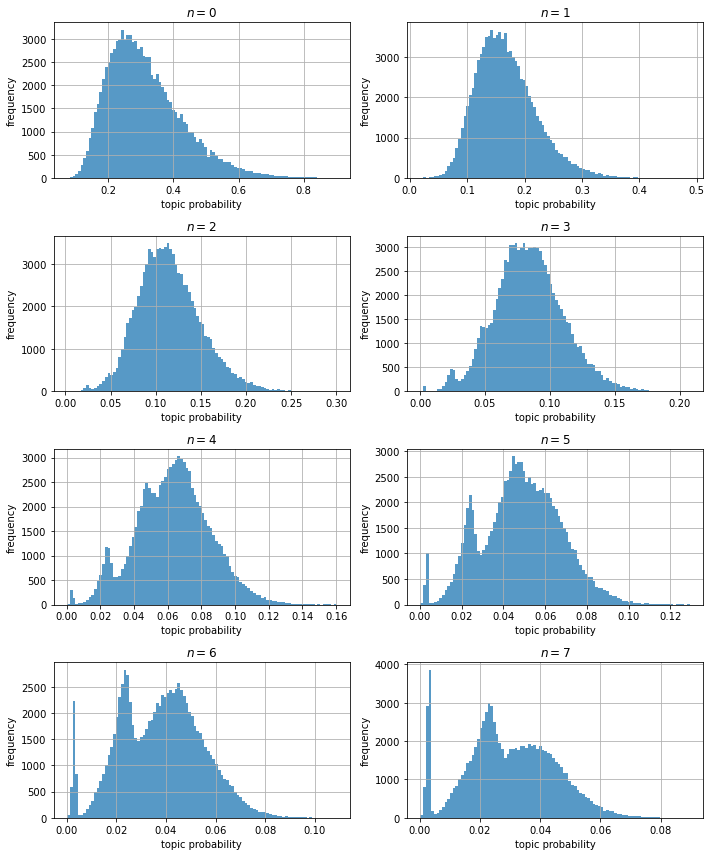

In [10]:
fig, ax = plt.subplots(4,2,figsize=(10,12))
for i in range(8):
    ax[i//2,i%2].hist(topic_i_p(dt, n_topics=1, start=i), bins=100, alpha=.75)
    
#     ax[i//2,i%2].axvline(0.003, color='green', linewidth=0.5)
#     ax[i//2,i%2].axvline(0.023, color='green', linewidth=0.5)
#     ax[i//2,i%2].axvline(0.046, color='green', linewidth=0.5)
    
    ax[i//2,i%2].grid()
    ax[i//2,i%2].set_title(f'$n={i}$')
    ax[i//2,i%2].set_xlabel('topic probability')
    ax[i//2,i%2].set_ylabel('frequency')

plt.tight_layout()
plt.savefig('figures/n_highest_topic_p.png', dpi=150)    
plt.show()

* changing shape of distribution (growing peaks around 0.02 & 0.04 - lda averages small amount of topic attention over many topics, so all end up with the around the same small value) 
* shape change visible in 2, strong in 3
* motivates decision to take sum of no more than top 2 topic probabilities

In [11]:
def plot_top_p_hist(dt, top_p=2, bins=100, title='', figsize=(8,5)):
    
    plt.figure(figsize=figsize)
    
    for i in range(top_p):
        plt.hist(topic_i_p(dt, start=i, n_topics=1), bins=np.linspace(0,1,bins), density=True,
                 alpha=0.5, label=f'{i}')
        
    plt.hist(topic_i_p(dt, start=0, n_topics=top_p), bins=np.linspace(0,1,bins), density=True,
             alpha=0.5, label=f'sum of {set(np.arange(top_p))}')
    
    plt.xlabel(f'topic probability', fontsize=14)
    plt.ylabel('frequency (probability density)', fontsize=14)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    legend = plt.legend(title='topic $n$', fontsize=12)
    plt.setp(legend.get_title(),fontsize=12)
    plt.title(title)
#     plt.grid()
    
#     plt.show()

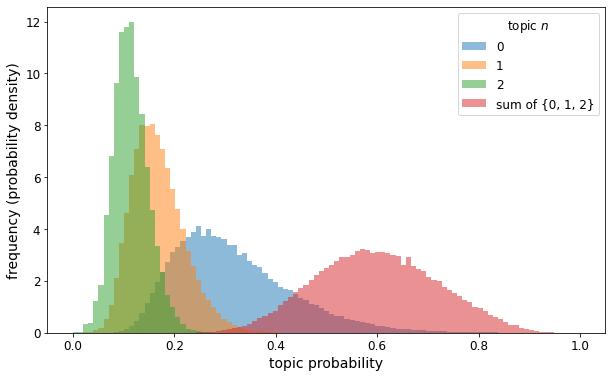

In [12]:
plot_top_p_hist(dt, 3, bins=100, figsize=(10,6))
plt.savefig('figures/top_3_prob_hist.png', dpi=150)

In [13]:
for i in np.linspace(0.4, 0.8, 5):
    print(i, len(np.where(topic_i_p(dt,3) > i)[0])/len(df))

0.4 0.9555710409341907
0.5 0.7826275168139537
0.6000000000000001 0.4864485339921658
0.7000000000000001 0.20742664681722678
0.8 0.050014253587152765


In [14]:
inds = np.where(topic_i_p(dt,3) < 0.6)[0]
print('no. speeches:', len(inds), '\n')
ind = np.random.choice(inds)
# ind = np.random.choice(np.where(Ieff > 40)[0])
review_doc(ind, 3)

no. speeches: 48640 

doc id: 86944 

top 3 topic ps: 0.519385480066425 

Largest doc topic probs [0.27343946 0.13132938 0.11461664 0.06718797 0.06661472 0.05699452
 0.052182   0.03478635 0.03299627 0.02883165 0.02639972 0.02583066] 

0.273 137
0.090*"deal" + 0.039*"vote" + 0.038*"brexit" + 0.020*"prime_minister" + 0.014*"leave" + 0.013*"eu" + 0.013*"withdrawal_agreement" + 0.011*"backstop" + 0.010*"parliament" + 0.008*"deliver"

0.131 55
0.055*"european" + 0.039*"eu" + 0.029*"europe" + 0.024*"european_union" + 0.021*"state" + 0.018*"treaty" + 0.015*"uk" + 0.013*"commission" + 0.012*"council" + 0.011*"opt"

0.115 79
0.014*"view" + 0.013*"case" + 0.012*"decision" + 0.012*"gentleman" + 0.011*"argument" + 0.011*"question" + 0.011*"matter" + 0.009*"position" + 0.009*"accept" + 0.009*"reason"

0.067 143
0.124*"amendment" + 0.075*"clause" + 0.054*"bill" + 0.021*"committee" + 0.021*"table" + 0.012*"provision" + 0.010*"provide" + 0.010*"accept" + 0.009*"place" + 0.009*"seek"

0.067 49
0.035*"g

## Plot no. lemmas vs sum of topic probs

In [15]:
length = df.lemmas_ngrams.apply(len).values

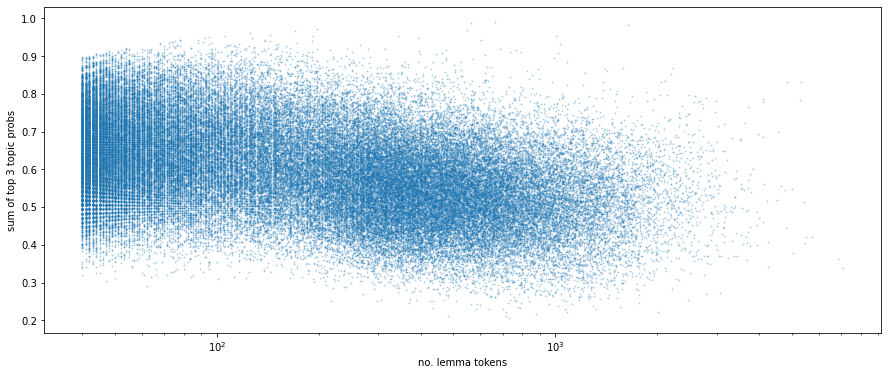

In [16]:
plt.figure(figsize=(15,6))
plt.scatter(length, topic_i_p(dt, start=0, n_topics=3), s=1, alpha=0.25)
plt.xlabel('no. lemma tokens')
plt.ylabel('sum of top 3 topic probs')
plt.xscale('log')
# plt.yscale('log')

# Filter speeches

## **Filter by top-3 topic sum threshold**

In [17]:
thresholds = np.linspace(0.4, 0.8, 5)
thresholds

array([0.4, 0.5, 0.6, 0.7, 0.8])

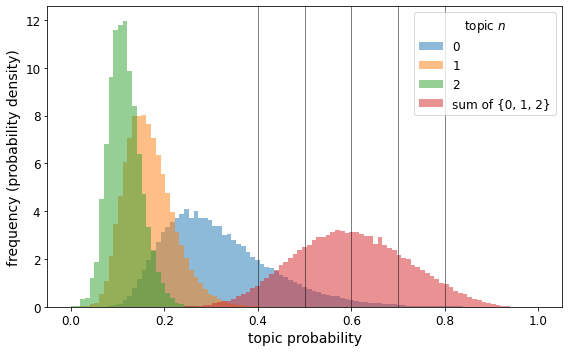

In [18]:
# plot_top_p_hist(dt, 3, 50)
plot_top_p_hist(dt, 3, bins=100, figsize=(8,5))
for t in thresholds:
    plt.axvline(t, linewidth=0.5, color='k')
plt.savefig('figures/top_3_prob_hist_thresholds.png', dpi=150)
plt.tight_layout()
plt.show()

In [23]:
filter_inds = {}

for t in thresholds:
    print(np.around(t, 1))
    inds_t = np.where((topic_i_p(dt,3) > t))[0]
    filter_inds[np.around(t, 1)] = inds_t
    print('retained', inds_t.shape[0])
    print('removed', dt.shape[0] - inds_t.shape[0])
    print('removed %', 100 * np.around((dt.shape[0] - inds_t.shape[0])/dt.shape[0], 3))
    print('\r')

0.4
retained 90505
removed 4208
removed % 4.3999999999999995

0.5
retained 74125
removed 20588
removed % 21.7

0.6
retained 46073
removed 48640
removed % 51.4

0.7
retained 19646
removed 75067
removed % 79.3

0.8
retained 4737
removed 89976
removed % 95.0



In [21]:
filter_inds.keys()

dict_keys([0.4, 0.5, 0.6, 0.7, 0.8])

In [23]:
with open('filter_inds.pkl', 'wb') as f:
    pickle.dump(filter_inds, f)